In [132]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Apache Spark on Dataproc - Bank Marketing Demo

Demo video link - https://www.youtube.com/watch?v=RbLOi1Cgsmo&feature=emb_title

![Apache Spark on Dataproc - Bank Marketing Demo](https://github.com/tfayyaz/cloud-dataproc/raw/fab205057b5fd4f3138ae6858212f1594b43df63/notebooks/examples/datalake_spark_bank_demo.png)

Apache Spark on Dataproc provides features to allow you to build an end to end solution for a wide number of use cases. This demo notebook focuses on using data from a financial services company who can build a data lake on Google Cloud and show how data enginers, data analysts and data scientists can use Apache Spark can work together to build a model to predict if a customer campaign will result in a deposit being made.

This notebook can be easily adapted to show to build a model to predict if a loan should be approved as shown in the video above.

## 1. Set-up Data Lake and Dataproc

This demo is designed to be run on Google Cloud Dataproc. Follow these steps to create create a Dataproc Cluster and then copy the notebook to your notebooks folder.

These steps should be run in the [Google Cloud Shell](https://cloud.google.com/shell)

### 1.1 - Set env configuration

```
export REGION=us-central1
export PROJECT_ID=<project-id>
```

### 1.2 - Create GCS bucket

#### GCS bucket for Dataproc Clusters and Hive Warehouse

```
export BUCKET_NAME=${PROJECT_ID}-demo

gsutil mb -l ${REGION} gs://${BUCKET_NAME}
```

### 1.3 - Create a Hive Metastore

_Note: [Dataproc Metastore](https://cloud.google.com/blog/products/data-analytics/cloud-hive-metastore-now-available) is now available in private Alpha. This section can be replaced with Dataproc Metastore if you have access_

#### 1.3.1. Create a Hive Cloud SQL database

```
gcloud sql instances create hive-metastore-db \
    --database-version="MYSQL_5_7" \
    --activation-policy=ALWAYS \
    --region ${REGION}
```

#### 1.3.2. Create a Hive Metastore Dataproc Cluster

Once the Cloud SQL instance is created create a new Dataproc hive metastore cluster that connects to the cluster.

```
gcloud dataproc clusters create hive-cluster \
    --async \
    --scopes sql-admin \
    --image-version 1.5 \
    --region ${REGION} \
    --initialization-actions gs://goog-dataproc-initialization-actions-${REGION}/cloud-sql-proxy/cloud-sql-proxy.sh \
    --properties hive:hive.metastore.warehouse.dir=gs://${BUCKET_NAME}/hive-warehouse \
    --metadata "hive-metastore-instance=${PROJECT_ID}:${REGION}:hive-metastore-db"
```

### 1.4 - Create Dataproc cluster with Jupyter, Rapids and GPUs

#### 1.4.1. Create Cluster

```
export CLUSTER_NAME=jupyter-gpu-cluster
export NUM_GPUS=2
export NUM_WORKERS=2

gcloud dataproc clusters create $CLUSTER_NAME  \
    --region $REGION \
    --image-version=preview-ubuntu \
    --master-machine-type n1-standard-4 \
    --num-workers $NUM_WORKERS \
    --worker-accelerator type=nvidia-tesla-t4,count=$NUM_GPUS \
    --worker-machine-type n1-highmem-4\
    --initialization-actions gs://goog-dataproc-initialization-actions-${REGION}/gpu/install_gpu_driver.sh,gs://goog-dataproc-initialization-actions-${REGION}/rapids/rapids.sh \
    --optional-components=ANACONDA,JUPYTER \
    --metadata gpu-driver-provider="NVIDIA" \
    --metadata rapids-runtime=SPARK \
    --scopes https://www.googleapis.com/auth/cloud-platform \
    --bucket $BUCKET_NAME \
    --enable-component-gateway \
    --properties="^#^spark:spark.yarn.unmanagedAM.enabled=false"
```

### 1.5 - Go to JupyterLab and copy this notebook

Once your cluster is ready go follow these steps to copy this notebook:

- On the Dataproc cluster UI go to web interfaces tab 
- Cick on the link to open JupyterLab.
- Go the Local Disk folder in JupyterLab
- Click on the plus (+) button to open the launcher
- Open terminal and run the cmd below to copy the notebook to your cluster

```
wget https://raw.githubusercontent.com/tfayyaz/cloud-dataproc/master/notebooks/examples/Spark%20-%20Bank%20Marketing%20Demo.ipynb
```



### 1.6 - Run example code in this notebook broken down into these sections

- Data Engineer - Convert CSV to Hive Tables (Parquet format)
- Data Analyst - Run SQL on tables and plot data
- Data Scientist - Create ML models with Spark
- Data Ops - Deploy Spark pipeline using Dataproc Workflows

In [154]:
# Run this to stop any currently running spark sessions 
# spark.stop()

## 2. Data Engineering - Process CSV files into Hive Tables (Parquet)

### Create Spark session with Hive Enabled

Create a Spark session, connect to Hive Metastore and enable Hive support in Spark

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType, IntegerType, StructField, StructType

warehouse_location = 'gs://<project-id>-demo/hive-warehouse'
service_endpoint = 'thrift://hive-cluster-m.us-central1-f:9083'

from pyspark.sql import SparkSession
spark = SparkSession.builder \
  .appName('Spark - Data Eng Demo') \
  .config("hive.metastore.uris", service_endpoint)  \
  .config("spark.sql.warehouse.dir", warehouse_location) \
  .enableHiveSupport() \
  .getOrCreate()

Check the first 1000 bytes of a file on GCS

In [6]:
!gsutil cat -h -r 0-1000 gs://cloud-ml-tables-data/bank-marketing.csv

==> gs://cloud-ml-tables-data/bank-marketing.csv <==
Age,Job,MaritalStatus,Education,Default,Balance,Housing,Loan,Contact,Day,Month,Duration,Campaign,PDays,Previous,POutcome,Deposit
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,1
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,1
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,1
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,1
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,1
35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,1
28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,1
42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,1
58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,1
43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,1
41,admin.,divorced,secondary,

### Get Spark application ID 

This is useful to easily fine application in the Spark History UI

In [39]:
spark.conf.get("spark.app.id")

'application_1598619717300_0026'

Check what databases are in the Hive Warehouse

In [3]:
spark.sql("""
SHOW DATABASES;
""").show()

+--------------------+
|           namespace|
+--------------------+
|        bank_demo_db|
|             default|
|house_prices_demo_db|
|     housing_demo_db|
+--------------------+



In [4]:
spark.sql("DESCRIBE DATABASE EXTENDED default").show(5, False)

+-------------------------+------------------------------------------+
|database_description_item|database_description_value                |
+-------------------------+------------------------------------------+
|Database Name            |default                                   |
|Comment                  |Default Hive database                     |
|Location                 |gs://dataproc-datalake-demo/hive-warehouse|
|Owner                    |public                                    |
|Properties               |                                          |
+-------------------------+------------------------------------------+



Create a new database called bank_demo_db

In [5]:
spark.sql("""
CREATE DATABASE IF NOT EXISTS bank_demo_db;
""").show()

++
||
++
++



In [6]:
spark.sql("DESCRIBE DATABASE EXTENDED bank_demo_db").show(5, False)

+-------------------------+----------------------------------------------------------+
|database_description_item|database_description_value                                |
+-------------------------+----------------------------------------------------------+
|Database Name            |bank_demo_db                                              |
|Comment                  |                                                          |
|Location                 |gs://dataproc-datalake-demo/hive-warehouse/bank_demo_db.db|
|Owner                    |root                                                      |
|Properties               |                                                          |
+-------------------------+----------------------------------------------------------+



Load the CSV file into a Spark Dataframe

In [7]:
df_bank_marketing = spark \
  .read \
  .option ( "inferSchema" , "true" ) \
  .option ( "header" , "true" ) \
  .csv ( "gs://cloud-ml-tables-data/bank-marketing.csv" )

df_bank_marketing.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Job: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Default: string (nullable = true)
 |-- Balance: integer (nullable = true)
 |-- Housing: string (nullable = true)
 |-- Loan: string (nullable = true)
 |-- Contact: string (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Duration: integer (nullable = true)
 |-- Campaign: integer (nullable = true)
 |-- PDays: integer (nullable = true)
 |-- Previous: integer (nullable = true)
 |-- POutcome: string (nullable = true)
 |-- Deposit: integer (nullable = true)



In [8]:
df_bank_marketing.show(5)

+---+------------+-------------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|Age|         Job|MaritalStatus|Education|Default|Balance|Housing|Loan|Contact|Day|Month|Duration|Campaign|PDays|Previous|POutcome|Deposit|
+---+------------+-------------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 58|  management|      married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown|      1|
| 44|  technician|       single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown|      1|
| 33|entrepreneur|      married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown|      1|
| 47| blue-collar|      married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown|      1|
| 33|     unknown|  

Run transformations on the data

In [43]:
## Any transformations on your data can be done at this point

Save the dataframe as a Hive table in Parquet format

In [9]:
df_bank_marketing.write.mode('overwrite').format("parquet").saveAsTable("bank_demo_db.bank_marketing")

Check that table was created

In [10]:
spark.sql("SHOW TABLES in bank_demo_db").show()

+------------+--------------+-----------+
|    database|     tableName|isTemporary|
+------------+--------------+-----------+
|bank_demo_db|bank_marketing|      false|
+------------+--------------+-----------+



In [11]:
spark.sql("DESCRIBE TABLE EXTENDED bank_demo_db.bank_marketing").show(100, False)

+----------------------------+-------------------------------------------------------------------------+-------+
|col_name                    |data_type                                                                |comment|
+----------------------------+-------------------------------------------------------------------------+-------+
|Age                         |int                                                                      |null   |
|Job                         |string                                                                   |null   |
|MaritalStatus               |string                                                                   |null   |
|Education                   |string                                                                   |null   |
|Default                     |string                                                                   |null   |
|Balance                     |int                                                               

### Compute statistics for columns in table

In [12]:
spark.sql("DESCRIBE TABLE EXTENDED bank_demo_db.bank_marketing Age").show()

+--------------+----------+
|     info_name|info_value|
+--------------+----------+
|      col_name|       Age|
|     data_type|       int|
|       comment|      NULL|
|           min|      NULL|
|           max|      NULL|
|     num_nulls|      NULL|
|distinct_count|      NULL|
|   avg_col_len|      NULL|
|   max_col_len|      NULL|
|     histogram|      NULL|
+--------------+----------+



In [13]:
cols = "Age, Job, MaritalStatus"
analyzeTableSQL = "ANALYZE TABLE bank_demo_db.bank_marketing COMPUTE STATISTICS FOR COLUMNS Age, Job, MaritalStatus"
spark.sql(analyzeTableSQL).show()

++
||
++
++



In [14]:
cols = "Age, Job, MaritalStatus"
analyzeTableSQL = "ANALYZE TABLE bank_demo_db.bank_marketing COMPUTE STATISTICS FOR ALL COLUMNS"
spark.sql(analyzeTableSQL).show()

++
||
++
++



In [15]:
spark.sql("DESCRIBE TABLE EXTENDED bank_demo_db.bank_marketing Age").show()

+--------------+----------+
|     info_name|info_value|
+--------------+----------+
|      col_name|       Age|
|     data_type|       int|
|       comment|      NULL|
|           min|        18|
|           max|        95|
|     num_nulls|         0|
|distinct_count|        76|
|   avg_col_len|         4|
|   max_col_len|         4|
|     histogram|      NULL|
+--------------+----------+



In [16]:
spark.sql("DESCRIBE TABLE EXTENDED bank_demo_db.bank_marketing Job").show()

+--------------+----------+
|     info_name|info_value|
+--------------+----------+
|      col_name|       Job|
|     data_type|    string|
|       comment|      NULL|
|           min|      NULL|
|           max|      NULL|
|     num_nulls|         0|
|distinct_count|        11|
|   avg_col_len|        10|
|   max_col_len|        13|
|     histogram|      NULL|
+--------------+----------+



You can now also see how many rows are in the table

In [19]:
spark.sql("DESCRIBE TABLE EXTENDED bank_demo_db.bank_marketing").show(100, False)

+----------------------------+-------------------------------------------------------------------------+-------+
|col_name                    |data_type                                                                |comment|
+----------------------------+-------------------------------------------------------------------------+-------+
|Age                         |int                                                                      |null   |
|Job                         |string                                                                   |null   |
|MaritalStatus               |string                                                                   |null   |
|Education                   |string                                                                   |null   |
|Default                     |string                                                                   |null   |
|Balance                     |int                                                               

## 3. Data Analyst - Run SQL on tables and plot data

In [17]:
spark.sql("""
SELECT 
    Deposit,
    COUNT(*) as count
FROM bank_demo_db.bank_marketing
GROUP BY Deposit
""").show()

+-------+-----+
|Deposit|count|
+-------+-----+
|      1|39922|
|      2| 5289|
+-------+-----+



In [136]:
spark.sql("""
SELECT 
    Job, 
    AVG(Age) as avg_age,
    AVG(Balance) as avg_balance
FROM bank_demo_db.bank_marketing
GROUP BY JOB
ORDER BY avg_age DESC
""").show()

+-------------+------------------+------------------+
|          Job|           avg_age|       avg_balance|
+-------------+------------------+------------------+
|      retired| 61.62676678445229| 1984.215106007067|
|      unknown|          47.59375| 1772.357638888889|
|    housemaid| 46.41532258064516|1392.3951612903227|
| entrepreneur| 42.19098856758574| 1521.470073974445|
|   unemployed| 40.96162701458174|1521.7459708365311|
|self-employed| 40.48448385053832|1647.9708676377454|
|   management| 40.44956650454642|1763.6168323112709|
|  blue-collar|  40.0440813810111|1078.8266543362104|
|   technician| 39.31459786757931|1252.6320916151112|
|       admin.| 39.28988590214659| 1135.838909301876|
|     services|38.740250361097736| 997.0881078478575|
|      student|26.542643923240938|1388.0607675906183|
+-------------+------------------+------------------+



### Spark to Pandas DataFrame

Enable Apache Arrow to allow faster conversion from Spark DataFrame to Pandas DataFrame.

In [19]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [20]:
df_jobs = spark.sql("""
SELECT 
    Job, 
    AVG(Age) as avg_age,
    AVG(Balance) as avg_balance
FROM bank_demo_db.bank_marketing
GROUP BY JOB
ORDER BY avg_age DESC
""").toPandas()

In [21]:
df_jobs.head()

,Job,avg_age,avg_balance
0,retired,61.626767,1984.215106
1,unknown,47.593750,1772.357639
2,housemaid,46.415323,1392.395161
3,entrepreneur,42.190989,1521.470074
4,unemployed,40.961627,1521.745971


### Plot data using Pandas Plotting

In [22]:
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='Job'>

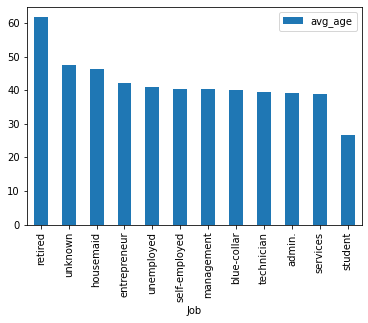

In [23]:
df_jobs.plot.bar(x='Job', y='avg_age', rot=90)

In [24]:
df_jobs.set_index('Job', inplace=True)
df_jobs.head()

,avg_age,avg_balance
Job,,
retired,61.626767,1984.215106
unknown,47.593750,1772.357639
housemaid,46.415323,1392.395161
entrepreneur,42.190989,1521.470074
unemployed,40.961627,1521.745971


array([<AxesSubplot:title={'center':'avg_age'}, xlabel='Job'>,
       <AxesSubplot:title={'center':'avg_balance'}, xlabel='Job'>],
      dtype=object)

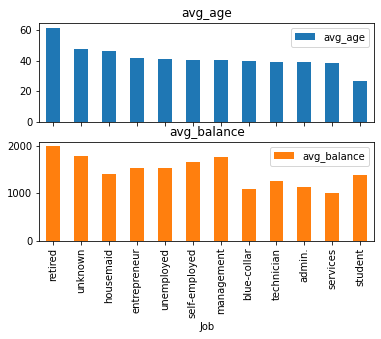

In [25]:
df_jobs.plot.bar(rot=90, subplots=True)

## 4. Data Scientist - Create ML models with Spark

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

Create a Spark DataFrame from hive table

In [3]:
data = spark.sql("""
SELECT * 
FROM bank_demo_db.bank_marketing
""")

Cache the DataFrame in memory 

In [4]:
data.cache()

DataFrame[Age: int, Job: string, MaritalStatus: string, Education: string, Default: string, Balance: int, Housing: string, Loan: string, Contact: string, Day: int, Month: string, Duration: int, Campaign: int, PDays: int, Previous: int, POutcome: string, Deposit: int]

In [5]:
data.groupBy("Deposit").count().show()

+-------+-----+
|Deposit|count|
+-------+-----+
|      1|39922|
|      2| 5289|
+-------+-----+



### Split training and test data

In [6]:
(train_data, test_data) = data.randomSplit([0.7, 0.3], seed=42)

In [7]:
train_data.groupBy("Deposit").count().show()

+-------+-----+
|Deposit|count|
+-------+-----+
|      1|28004|
|      2| 3709|
+-------+-----+



In [8]:
train_data.count()

31713

In [9]:
test_data.count()

13498

## Create Spark ML Pipeline

Train a RandomForestClassifier model

In [10]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.classification import RandomForestClassifier


categorical_cols = [field for (field, data_type) in train_data.dtypes 
                    if ((data_type == "string") & (field != 'Deposit'))]

index_output_cols = [x + "_Index" for x in categorical_cols]

ohe_output_cols = [x + "_OHE" for x in categorical_cols]

categorical_string_indexer = StringIndexer(
    inputCols=categorical_cols,
    outputCols=index_output_cols,
    handleInvalid="skip")

ohe_encoder = OneHotEncoder(
    inputCols=index_output_cols,
    outputCols=ohe_output_cols)

numeric_cols = [field for (field, data_type) in train_data.dtypes 
                if (((data_type == "double") | (data_type == "int") | (data_type == "bigint"))
                  & (field != 'Deposit'))]

assembler_inputs = ohe_output_cols + numeric_cols

vec_assembler = VectorAssembler(
    inputCols=assembler_inputs,
    outputCol="features")

label_string_indexer = StringIndexer(). \
  setInputCol("Deposit"). \
  setOutputCol("label")

# Train a RandomForestClassifier model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

pipeline = Pipeline(stages=[
    categorical_string_indexer,
    ohe_encoder,
    vec_assembler,
    label_string_indexer,
    rf
])

# Train model on training data
pipeline_model = pipeline.fit(train_data)

# Make predictions on test.
predictions = pipeline_model.transform(test_data)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(5) 

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|  0.0|(42,[10,12,15,16,...|
|       0.0|  0.0|(42,[10,12,16,18,...|
|       0.0|  1.0|(42,[10,12,16,18,...|
|       0.0|  1.0|(42,[10,12,16,18,...|
|       0.0|  0.0|(42,[10,12,15,16,...|
+----------+-----+--------------------+
only showing top 5 rows



As the dataset is imbalanced a good metric is AUC: Area Under the ROC Curve. [Learn more about AUC here.](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc#AUC)

In [11]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

binaryEvaluator = BinaryClassificationEvaluator(labelCol="label")

auc = binaryEvaluator.evaluate(predictions, {binaryEvaluator.metricName: "areaUnderROC"})
print(auc)

0.8867264917867028


In [12]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

predictions_np = np.array((predictions.select("label","prediction").collect()))

np_acc = accuracy_score(predictions_np[:,0], predictions_np[:,1])
np_f1 = f1_score(predictions_np[:,0], predictions_np[:,1])
np_precision = precision_score(predictions_np[:,0], predictions_np[:,1])
np_recall = recall_score(predictions_np[:,0], predictions_np[:,1])
np_auc = roc_auc_score(predictions_np[:,0], predictions_np[:,1])

print("f1:", np_f1)
print("precision:", np_precision)
print("recall:", np_recall)

f1: 0.08268424206111442
precision: 0.7752808988764045
recall: 0.043670886075949364


In [13]:
# import package that will generate the confusion matrix scores
from sklearn.metrics import confusion_matrix
# import packages that will help display the scores
import pandas as pd

confusion_matrix_scores = confusion_matrix(predictions_np[:,0], 
                                           predictions_np[:,1], 
                                           labels=[1, 0])

# display scores as a heatmap
df = pd.DataFrame(confusion_matrix_scores, 
                  columns = ["Predicted True", "Predicted Not True"],
                  index = ["Actually True", "Actually Not True"])


df.head()

,Predicted True,Predicted Not True
Actually True,69,1511
Actually Not True,20,11898


## Improve model using XGBoost

Train model using XGBoost

In [2]:
# spark.stop()

In [1]:
from pyspark.sql import SparkSession

warehouse_location = 'gs://dataproc-datalake-demo/hive-warehouse'
service_endpoint = 'thrift://hive-cluster-m.us-central1-f:9083'

spark = SparkSession.builder \
  .appName('Hive and XGBoost - GPU') \
  .config('spark.jars.packages', 'com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.17.1') \
  .config("spark.rapids.memory.gpu.pooling.enabled", "false") \
  .config("spark.executor.instances", "4") \
  .config("spark.executor.cores", "2") \
  .config("spark.task.cpus", "2") \
  .config("spark.task.resource.gpu.amount", "1") \
  .config("hive.metastore.uris", service_endpoint)  \
  .config("spark.sql.warehouse.dir", warehouse_location) \
  .enableHiveSupport() \
  .getOrCreate()

In [4]:
spark.conf.get("spark.app.id")

'application_1599581036896_0008'

In [14]:
data = spark.sql("""
SELECT * 
FROM bank_demo_db.bank_marketing
""")

(train_data, test_data) = data.randomSplit([0.7, 0.3], seed=42)

train_data.cache()
train_data.show(3)

test_data.cache()
test_data.show(3)

+---+-------+-------------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+-------+
|Age|    Job|MaritalStatus|Education|Default|Balance|Housing|Loan| Contact|Day|Month|Duration|Campaign|PDays|Previous|POutcome|Deposit|
+---+-------+-------------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+-------+
| 18|student|       single|  primary|     no|    608|     no|  no|cellular| 12|  aug|     267|       1|   -1|       0| unknown|      2|
| 18|student|       single|  primary|     no|    608|     no|  no|cellular| 13|  nov|     210|       1|   93|       1| success|      2|
| 18|student|       single|secondary|     no|      5|     no|  no|cellular| 24|  aug|     143|       2|   -1|       0| unknown|      1|
+---+-------+-------------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+-------+
only showing top 3 rows

+---+-------+----------

## Create ML Pipeline with XGBoost model

In [15]:
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from ml.dmlc.xgboost4j.scala.spark import XGBoostClassificationModel, XGBoostClassifier

categorical_cols = [field for (field, data_type) in train_data.dtypes 
                    if ((data_type == "string") & (field != 'Deposit'))]

string_index_output_cols = [x + "_Index" for x in categorical_cols]

categorical_string_indexer = StringIndexer(
    inputCols=categorical_cols,
    outputCols=string_index_output_cols,
    handleInvalid="skip")

numeric_cols = [field for (field, data_type) in train_data.dtypes 
                if (((data_type == "double") | (data_type == "int") | (data_type == "bigint"))
                  & (field != 'Deposit'))]

features = string_index_output_cols + numeric_cols

label_string_indexer = StringIndexer(). \
  setInputCol("Deposit"). \
  setOutputCol("label")

params = { 
    'treeMethod': 'gpu_hist',
    'maxDepth': 10, 
    'maxLeaves': 256,
    'growPolicy': 'depthwise',
    'objective': 'binary:logistic',
    'numRound': 100,
    'numWorkers': 2
}

# For GPU you must use .setFeaturesCols(features) and pass in the list of columns that are the features
xgbc = XGBoostClassifier(**params).setLabelCol("label").setFeaturesCols(features)

# For CPU training you must use .setFeaturesCol('features') which 
# expects the features to be vectorised into one column first
# xgbc = XGBoostClassifier(**params).setLabelCol('label').setFeaturesCol('features')

pipeline = Pipeline(stages=[
    categorical_string_indexer,
    label_string_indexer,
    xgbc
])

In [16]:
%%time
# Train model on training data
pipeline_model = pipeline.fit(train_data)

CPU times: user 74.4 ms, sys: 18.3 ms, total: 92.7 ms
Wall time: 20.1 s


In [17]:
# Make predictions on test

predictions = pipeline_model.transform(test_data)
predictions.select("prediction", "label").show(5)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       0.0|  0.0|
|       1.0|  1.0|
|       0.0|  1.0|
|       0.0|  0.0|
+----------+-----+
only showing top 5 rows



In [18]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

binaryEvaluator = BinaryClassificationEvaluator(labelCol="label")

auc = binaryEvaluator.evaluate(predictions, {binaryEvaluator.metricName: "areaUnderROC"})
print(auc)

0.9261211368401443


### View model stats using Numpy and Scikit-learn

PySpark cannot be used to calculate the precision, recall, and f1_score for binary classification evaluation and therefore sklearn.metrics is used

In [19]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

predictions_np = np.array((predictions.select("label","prediction").collect()))

np_acc = accuracy_score(predictions_np[:,0], predictions_np[:,1])
np_f1 = f1_score(predictions_np[:,0], predictions_np[:,1])
np_precision = precision_score(predictions_np[:,0], predictions_np[:,1])
np_recall = recall_score(predictions_np[:,0], predictions_np[:,1])
np_auc = roc_auc_score(predictions_np[:,0], predictions_np[:,1])

print("f1:", np_f1)
print("precision:", np_precision)
print("recall:", np_recall)

f1: 0.5221674876847291
precision: 0.5879556259904913
recall: 0.46962025316455697


In [20]:
# import package that will generate the confusion matrix scores
from sklearn.metrics import confusion_matrix
# import packages that will help display the scores
import pandas as pd

confusion_matrix_scores = confusion_matrix(predictions_np[:,0], 
                                           predictions_np[:,1], 
                                           labels=[1, 0])

# display scores as a heatmap
df = pd.DataFrame(confusion_matrix_scores, 
                  columns = ["Predicted True", "Predicted Not True"],
                  index = ["Actually True", "Actually Not True"])


df.head()

,Predicted True,Predicted Not True
Actually True,742,838
Actually Not True,520,11398


### Save model_pipeline

In [148]:
from pyspark.ml import Pipeline, PipelineModel

model_path = 'gs://dataproc-datalake-examples/xgboost/pipeline_model/bank-marketing'

pipeline_model.write().overwrite().save(model_path)

In [149]:
loaded_pipeline_model = PipelineModel.load(model_path)

In [150]:
# Make predictions using loaded model

predictions = loaded_pipeline_model.transform(test_data)

predictions.show(5)

+---+-------+---+--------+--------+-----+--------+-------+-----------+---------+-------------------+--------------+-------------+-------------+---------------+----------+-------------+-----+--------------------+--------------------+----------+
|Age|Balance|Day|Duration|Campaign|PDays|Previous|Deposit|Month_Index|Job_Index|MaritalStatus_Index|POutcome_Index|Housing_Index|Contact_Index|Education_Index|Loan_Index|Default_Index|label|       rawPrediction|         probability|prediction|
+---+-------+---+--------+--------+-----+--------+-------+-----------+---------+-------------------+--------------+-------------+-------------+---------------+----------+-------------+-----+--------------------+--------------------+----------+
| 18|   1944| 10|     122|       3|   -1|       0|      1|        2.0|     10.0|                1.0|           0.0|          1.0|          2.0|            2.0|       0.0|          0.0|  0.0|[6.82134294509887...|[0.99891093163751...|       0.0|
| 18|     35| 21|     10

### Save prediction results to a new table

In [151]:
predictions.write.mode('overwrite').format("parquet").saveAsTable("bank_demo_db.bank_marketing_predictions")

In [152]:
spark.sql("SHOW TABLES in bank_demo_db").show(10, False)

+------------+--------------------------+-----------+
|database    |tableName                 |isTemporary|
+------------+--------------------------+-----------+
|bank_demo_db|bank_marketing            |false      |
|bank_demo_db|bank_marketing_predictions|false      |
+------------+--------------------------+-----------+



## 5. Data Ops - Deploy Spark pipeline using Dataproc Workflows

### Dataproc Workflows

Dataproc Workflows has 2 types of workflow templates.

1. Manged cluster - Create a new cluster and delete the cluster once the job has completed.
2. Cluster selector - Select a pre-existing Dataproc cluster to the run the jobs (does not delete the cluster).

This codelab will use option 1 to create a managed cluster workflow template.

### 5.1 Convert code above into 2 python files

1. Job to convert CSV to Hive Tables
2. Job to run predictions on Hive Tables

In [8]:
%%writefile job_csv_to_hive.py
## Job 1
print('Job 1')
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

warehouse_location = 'gs://dataproc-datalake-demo/hive-warehouse'
service_endpoint = 'thrift://hive-cluster-m.us-central1-f:9083'

spark = SparkSession.builder \
  .appName('csv_to_hive') \
  .config("hive.metastore.uris", service_endpoint)  \
  .config("spark.sql.warehouse.dir", warehouse_location) \
  .enableHiveSupport() \
  .getOrCreate()

#To-Do add code from notebook job 1 

Writing job_csv_to_hive.py


In [11]:
%%writefile job_xgboost_predictions.py
## Job 2
print('Job 2')

# Load the data
data = spark.sql("""
SELECT * 
FROM bank_demo_db.bank_marketing
""")

model_path = 'gs://dataproc-datalake-examples/xgboost/pipeline_model/bank-marketing'

loaded_model = XGBoostClassificationModel().load(model_path)

loaded_pipeline_model = PipelineModel.load(model_path)

#To-Do add code from notebook job 2 

Writing job_xgboost_predictions.py


### 5.2. Grant service account permission to deploy workflow from notebooks

Dataproc's service accounts needs to be granted "Dataproc Editor" IAM role.

Go to https://console.cloud.google.com/iam-admin/iam

Look for the service account email under the name "Google Cloud Dataproc Service Agent". It will be in the format

```bash
service-{project-number}@dataproc-accounts.iam.gserviceaccount.com
```

Edit the roles and add the role "Dataproc Editor" and press save.

In [79]:
## Alternatively run all of the below from the Google Cloud Shell

### 5.3 Create Dataproc managed cluster workflow Template

In [20]:
%%bash
export WORKFLOW_ID=bank-marketing-workflow

In [22]:
%%bash
export WORKFLOW_ID=bank-marketing-workflow
echo $WORKFLOW_ID

bank-marketing-workflow


In [23]:
%%bash
export WORKFLOW_ID=bank-marketing-workflow
export REGION=us-central1

gcloud dataproc workflow-templates create $WORKFLOW_ID \
--region $REGION

### 5.4 Configure managed cluster for the workflow template

In [24]:
%%bash
export WORKFLOW_ID=bank-marketing-workflow

export PROJECT_ID=dataproc-datalake
export CLUSTER_NAME=spark-workflow-cluster
export BUCKET_NAME=${PROJECT_ID}-demo
export REGION=us-central1
export ZONE=us-central1-f

gcloud beta dataproc workflow-templates set-managed-cluster $WORKFLOW_ID \
    --cluster-name $CLUSTER_NAME \
    --region $REGION \
    --zone $ZONE \
    --image-version preview-ubuntu \
    --master-machine-type n1-standard-4 \
    --worker-machine-type n1-standard-4 \
    --optional-components=ANACONDA,JUPYTER \
    --initialization-actions gs://goog-dataproc-initialization-actions-${REGION}/rapids/rapids.sh \
    --metadata rapids-runtime=SPARK \
    --bucket $BUCKET_NAME

### 5.5 Upload PySpark job to GCS

In [10]:
%%bash
export PROJECT_ID=dataproc-datalake
export BUCKET_NAME=${PROJECT_ID}-demo
gsutil cp job_csv_to_hive.py \
 gs://${PROJECT_ID}-demo/workflows/spark-bank-marketing/job_csv_to_hive.py

Copying file://job_csv_to_hive.py [Content-Type=text/x-python]...
/ [1 files][   24.0 B/   24.0 B]                                                
Operation completed over 1 objects/24.0 B.                                       


In [13]:
%%bash
export PROJECT_ID=dataproc-datalake
export BUCKET_NAME=${PROJECT_ID}-demo
gsutil cp job_xgboost_predictions.py \
 gs://${PROJECT_ID}-demo/workflows/spark-bank-marketing/job_xgboost_predictions.py

Copying file://job_xgboost_predictions.py [Content-Type=text/x-python]...
/ [1 files][   24.0 B/   24.0 B]                                                
Operation completed over 1 objects/24.0 B.                                       


### 5.6 Add job to workflow template

In [34]:
%%bash
export WORKFLOW_ID=bank-marketing-workflow
export REGION=us-central1
export PROJECT_ID=dataproc-datalake

gcloud dataproc workflow-templates add-job pyspark \
  gs://${PROJECT_ID}-demo/workflows/spark-bank-marketing/job_csv_to_hive.py \
    --region $REGION \
    --step-id csv_to_hive \
    --workflow-template $WORKFLOW_ID

createTime: '2020-09-08T16:56:47.304Z'
id: bank-marketing-workflow
jobs:
- pysparkJob:
    mainPythonFileUri: gs://dataproc-datalake-demo/workflows/spark-bank-marketing/job_csv_to_hive.py
  stepId: csv_to_hive
name: projects/dataproc-datalake/regions/us-central1/workflowTemplates/bank-marketing-workflow
placement:
  managedCluster:
    clusterName: spark-workflow-cluster
    config:
      configBucket: dataproc-datalake-demo
      gceClusterConfig:
        metadata:
          rapids-runtime: SPARK
        zoneUri: us-central1-f
      initializationActions:
      - executableFile: gs://goog-dataproc-initialization-actions-us-central1/rapids/rapids.sh
        executionTimeout: 600s
      masterConfig:
        machineTypeUri: n1-standard-4
      softwareConfig:
        imageVersion: preview-ubuntu
        optionalComponents:
        - ANACONDA
        - JUPYTER
      workerConfig:
        machineTypeUri: n1-standard-4
updateTime: '2020-09-08T17:09:28.406Z'
version: 5


In [35]:
%%bash
export WORKFLOW_ID=bank-marketing-workflow
export REGION=us-central1
export PROJECT_ID=dataproc-datalake

gcloud dataproc workflow-templates add-job pyspark \
  gs://${PROJECT_ID}-demo/workflows/spark-bank-marketing/job_xgboost_predictions.py \
    --region $REGION \
    --start-after=csv_to_hive \
    --step-id xgboost_predictions \
    --workflow-template $WORKFLOW_ID

createTime: '2020-09-08T16:56:47.304Z'
id: bank-marketing-workflow
jobs:
- pysparkJob:
    mainPythonFileUri: gs://dataproc-datalake-demo/workflows/spark-bank-marketing/job_csv_to_hive.py
  stepId: csv_to_hive
- prerequisiteStepIds:
  - csv_to_hive
  pysparkJob:
    mainPythonFileUri: gs://dataproc-datalake-demo/workflows/spark-bank-marketing/job_xgboost_predictions.py
  stepId: xgboost_predictions
name: projects/dataproc-datalake/regions/us-central1/workflowTemplates/bank-marketing-workflow
placement:
  managedCluster:
    clusterName: spark-workflow-cluster
    config:
      configBucket: dataproc-datalake-demo
      gceClusterConfig:
        metadata:
          rapids-runtime: SPARK
        zoneUri: us-central1-f
      initializationActions:
      - executableFile: gs://goog-dataproc-initialization-actions-us-central1/rapids/rapids.sh
        executionTimeout: 600s
      masterConfig:
        machineTypeUri: n1-standard-4
      softwareConfig:
        imageVersion: preview-ubuntu
  

### 5.7 Run workflow template

In [36]:
%%bash
export WORKFLOW_ID=bank-marketing-workflow
export REGION=us-central1

gcloud dataproc workflow-templates instantiate $WORKFLOW_ID \
--region $REGION

Waiting on operation [projects/dataproc-datalake/regions/us-central1/operations/4072cbbe-c966-3708-b54d-4298354ab78a].
WorkflowTemplate [bank-marketing-workflow] PENDING
WorkflowTemplate [bank-marketing-workflow] RUNNING
Creating cluster: Operation ID [projects/dataproc-datalake/regions/us-central1/operations/db00b13c-d677-48ae-9f78-f2e29c693d08].
Created cluster: spark-workflow-cluster-zobjl64tmvq4s.
Job ID csv_to_hive-zobjl64tmvq4s RUNNING
Job ID csv_to_hive-zobjl64tmvq4s COMPLETED
Job ID xgboost_predictions-zobjl64tmvq4s COMPLETED
Deleting cluster: Operation ID [projects/dataproc-datalake/regions/us-central1/operations/0478b08a-944b-4d8a-99ba-1a013662ea2a].
WorkflowTemplate [bank-marketing-workflow] DONE
Deleted cluster: spark-workflow-cluster-zobjl64tmvq4s.


### 5.8 View Cluster, workflow and jobs tabs

Go to the Dataproc UI and view the cluster page. You should see the new cluster spinning up

Once the cluster is ready view the workflow and jobs tabs to check the progress of the jobs.

### 5.9 Check new predictions table was created

### 5.10 Schedule workflows

View the guide on how to schedule Dataproc workflows

https://cloud.google.com/dataproc/docs/concepts/workflows/workflow-schedule-solutions